## Importing Libs 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
from glob import glob
from imageio import imread
from torch.utils.data import Dataset,DataLoader,TensorDataset,random_split
from sklearn.model_selection import train_test_split

In [3]:
from models import *
from layers import *
from train import *
from test import *
from vision_dataloaders import *
from plots import *
from torchsummary import summary
from visualize import *
from diagnostics import *

## Load Data 

In [4]:
datapath = '/local/mnt/workspace/usr/rishubh/Study/EVA/S12/tiny-imagenet-200'

In [5]:
rlabel_dict={}
nlabel_dict={}
with open(datapath+'/wnids.txt','r') as f:
    for i,l in enumerate(f.readlines()):
        nlabel_dict[l.replace('\n','')]=i

rlabel_dict={}
with open(datapath+'/words.txt','r') as f:
    for l in f.readlines():
        k,v = l.split('\t')
        v=v.replace('\n','')
        if k in nlabel_dict:
            rlabel_dict[k] = v
            

train_dir = datapath+'/train'
all_images=[]
all_labels=[]
for k,v in tqdm_notebook(sorted(nlabel_dict.items(),key= lambda x:x[1])):
    nfiles = glob(train_dir+'/'+k+'/images/*.JPEG')
    nfiles = sorted(nfiles, key = lambda x: int(x.split('_')[1].split('.')[0]))
    for f in nfiles:
        all_images.append(imread(f,pilmode='RGB')[None,...])
        all_labels.append(v)


/usr2/rishkhur/.local/lib/python3.7/site-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [6]:
all_images=np.concatenate(all_images)
all_labels = np.array(all_labels)

print(all_images.shape,all_labels.shape)

all_idxs = np.arange(len(all_images))
train_idxs,valid_idxs = train_test_split(all_idxs,test_size=0.3)
train_images,train_labels = all_images[train_idxs].astype('float32'),all_labels[train_idxs]
valid_images,valid_labels = all_images[valid_idxs].astype('float32'),all_labels[valid_idxs]

print(f'Training Size-> {len(train_images)}')
print(f'Validation Size-> {len(valid_images)}')

(100000, 64, 64, 3) (100000,)
Training Size-> 70000
Validation Size-> 30000


### Getting normalization values

In [7]:
u,s=train_images.astype('float32').mean((0,1,2))/255,train_images.astype('float32').std((0,1,2))/255

In [8]:
u,s

(array([0.05874375, 0.05874375, 0.05874375], dtype=float32),
 array([0.2428459, 0.2428459, 0.2428459], dtype=float32))

In [9]:
mean_image = train_images.astype('float32').mean(0)

In [10]:
train_images-=mean_image
train_images/=128.

In [11]:
valid_images-=mean_image
valid_images/=128.

In [12]:
u=train_images.mean((0,1,2))

In [13]:
u

array([-1.6661972e-05,  1.6680865e-06,  6.7344627e-07], dtype=float32)

### Trying augmentations 

Need to apply augmentations as specified in the assignment:
Padding(8)-> random crop(64),FlipLR, cutout((16,16))

In [ ]:
aug_data = VisionData(images=train_images,labels=train_labels)

In [ ]:
img=[aug_data.images[20]]*32

In [ ]:
aug_data.images=np.array(img)

In [ ]:
assert np.allclose(aug_data[0][0],aug_data[1][0])

In [ ]:
tfms = create_transform(tfm_names=['normalize','pad','crop','hflip','cutout','tensor'],padded_size=(80,80),norm_constants=(u,s),
                        cutout_size=16,cutout_fillvalue=u,cutout_prob=1.,crop_size=(64,64))
                       

In [ ]:
tfms = create_transform(tfm_names=['hflip','cutout','tensor'],cutout_prob=1.,cutout_size=16,cutout_fillvalue=u)
                       

In [ ]:
aug_data.tfms=tfms

In [ ]:
tfms

In [ ]:
isCUDA = torch.cuda.is_available()
dev = torch.device('cuda') if isCUDA else torch.device('cpu')
dataloader_args = dict(shuffle=True,num_workers=4,batch_size = 8,pin_memory=True) if isCUDA else dict(shuffle=True,batch_size = 8//2)
dl=getDataLoader(aug_data,**dataloader_args)

In [ ]:
show_batch(dl,figsize=(16,16))

### Defining DataLoaders

In [16]:
train_tfms = create_transform(tfm_names=['hflip','cutout','tensor'],cutout_prob=1.,cutout_size=16
                              ,cutout_fillvalue=u,hsv_prob=0.2)                      
#train_tfms = create_transform(tfm_names=['hsv','hflip','tensor'],cutout_prob=0.5,cutout_size=16,cutout_fillvalue=u,hsv_prob=0.25)                      

test_tfms = create_transform(tfm_names=['tensor'])


train_ds = VisionData(images=train_images,labels=train_labels,tfms=train_tfms)
test_ds = VisionData(images=valid_images,labels=valid_labels,tfms=test_tfms)

train_dl,test_dl = getTrainTestLoader((train_ds,test_ds),BS=256)

In [17]:
train_ds[10][0].shape

torch.Size([3, 64, 64])

## Model development 

In [ ]:
model = ResNetImageNet().cuda()

In [ ]:
#model

In [ ]:
summary(model,input_size=(3,64,64))

## LR Range test

In [18]:
BATCH_SIZE=256
n_batches_per_epoch = train_ds.images.shape[0]//BATCH_SIZE+1
n_epochs = 5

In [19]:
model1 = ResNetImageNet(nc=200).cuda()
opt1 = optim.SGD(model1.parameters(),lr=1e-3,momentum=0.95,weight_decay=1e-4)
#opt1 = optim.Adam(model1.parameters(),lr=1e-3)

dls={}
dls['train']=train_dl
dls['valid']=test_dl
loss_func = nn.CrossEntropyLoss()
#sched = StepLR(opt,step_size=15,gamma=0.3)

In [20]:
finder = LRFinder(model1,opt1,loss_func)

In [21]:
finder.range_test(dls['train'],num_iter=n_batches_per_epoch*n_epochs,
                  metric='accuracy',step_mode='exp',
                  start_lr=1e-6,break_on_loss=False,end_lr=10)

100%|██████████| 1370/1370 [03:54<00:00,  5.84it/s]

Learning rate search is over. Please use self.plot to look at the graph


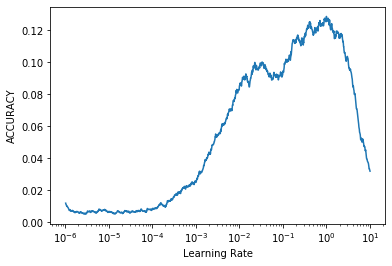

In [22]:
finder.plot(skip_start=0,to_plot='metric',lr_scale='log',skip_end=1)

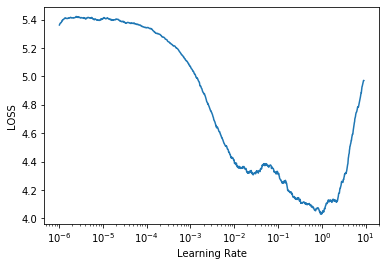

In [23]:
finder.plot(skip_start=0)#,to_plot='metric',lr_scale='log',skip_end=1)

In [24]:
finder.history['lr'][np.argmin(finder.history['loss'])]

0.9287166073262748

In [25]:
del model1
torch.cuda.empty_cache()

## Training Model 

In [26]:
model = ResNetImageNet(nc=200).cuda()
opt = optim.SGD(model.parameters(),lr=0.1,momentum=0.95,weight_decay=1e-4)
#opt = optim.Adam(model.parameters(),lr=3e-2)#,momentum=0.9)

dls={}
dls['train']=train_dl
dls['valid']=test_dl
BATCH_SIZE = 256
N_EPOCHS=50
total_steps = 50*len(dls['train'])
loss_func = nn.CrossEntropyLoss()
#sched = get_scheduler(opt,'reduce',patience=5)
sched = get_scheduler(opt,'onecycle',max_lr=0.9,pct_start=15/50,total_steps=total_steps
                      ,anneal_strategy='linear',div_factor=10,final_div_factor=20,
                      cycle_momentum=False,max_momentum=0.95,base_momentum=0.7)

In [27]:
ldict = train(model,opt,dls,loss_func,50,scheduler=sched,device='cuda',sched_batchwise=True)#,sched_loss=True)

Training Loss:4.232, Training Acc:8.036: 100%|██████████| 274/274 [00:46<00:00,  5.86it/s] 


  0%|          | 0/274 [00:00<?, ?it/s]


[0/50]--> Training Loss:4.717, Training Accuracy:5.069, Validation Loss:4.585, Validation Accuracy:6.803
Learning rate: 0.14401314188366998


Training Loss:3.929, Training Acc:15.179: 100%|██████████| 274/274 [00:46<00:00,  5.83it/s]


  0%|          | 0/274 [00:00<?, ?it/s]


[1/50]--> Training Loss:4.058, Training Accuracy:11.960, Validation Loss:3.941, Validation Accuracy:13.733
Learning rate: 0.19802628376734


Training Loss:3.502, Training Acc:26.786: 100%|██████████| 274/274 [00:47<00:00,  5.82it/s]


  0%|          | 0/274 [00:00<?, ?it/s]


[2/50]--> Training Loss:3.638, Training Accuracy:18.220, Validation Loss:3.627, Validation Accuracy:19.007
Learning rate: 0.25203942565101


Training Loss:3.538, Training Acc:23.214: 100%|██████████| 274/274 [00:47<00:00,  5.82it/s]


  0%|          | 0/274 [00:00<?, ?it/s]


[3/50]--> Training Loss:3.350, Training Accuracy:23.061, Validation Loss:3.431, Validation Accuracy:22.417
Learning rate: 0.30605256753468


Training Loss:3.274, Training Acc:28.571: 100%|██████████| 274/274 [00:47<00:00,  5.81it/s]


  0%|          | 0/274 [00:00<?, ?it/s]


[4/50]--> Training Loss:3.121, Training Accuracy:27.114, Validation Loss:4.103, Validation Accuracy:17.343
Learning rate: 0.36006570941835003


Training Loss:2.998, Training Acc:28.571: 100%|██████████| 274/274 [00:47<00:00,  5.81it/s]


  0%|          | 0/274 [00:00<?, ?it/s]


[5/50]--> Training Loss:2.949, Training Accuracy:30.694, Validation Loss:3.189, Validation Accuracy:27.057
Learning rate: 0.41407885130202005


Training Loss:3.062, Training Acc:26.786: 100%|██████████| 274/274 [00:47<00:00,  5.82it/s]


  0%|          | 0/274 [00:00<?, ?it/s]


[6/50]--> Training Loss:2.836, Training Accuracy:32.944, Validation Loss:3.517, Validation Accuracy:22.377
Learning rate: 0.46809199318568995


Training Loss:2.729, Training Acc:31.250: 100%|██████████| 274/274 [00:47<00:00,  5.81it/s]


  0%|          | 0/274 [00:00<?, ?it/s]


[7/50]--> Training Loss:2.744, Training Accuracy:34.326, Validation Loss:3.242, Validation Accuracy:27.870
Learning rate: 0.52210513506936


Training Loss:2.652, Training Acc:42.857: 100%|██████████| 274/274 [00:47<00:00,  5.82it/s]


  0%|          | 0/274 [00:00<?, ?it/s]


[8/50]--> Training Loss:2.689, Training Accuracy:35.463, Validation Loss:3.405, Validation Accuracy:25.407
Learning rate: 0.57611827695303


Training Loss:2.760, Training Acc:36.607: 100%|██████████| 274/274 [00:47<00:00,  5.82it/s]


  0%|          | 0/274 [00:00<?, ?it/s]


[9/50]--> Training Loss:2.664, Training Accuracy:36.297, Validation Loss:3.322, Validation Accuracy:26.577
Learning rate: 0.6301314188367


Training Loss:2.674, Training Acc:37.500: 100%|██████████| 274/274 [00:47<00:00,  5.83it/s]


  0%|          | 0/274 [00:00<?, ?it/s]


[10/50]--> Training Loss:2.629, Training Accuracy:36.919, Validation Loss:3.141, Validation Accuracy:28.893
Learning rate: 0.68414456072037


Training Loss:2.500, Training Acc:42.857: 100%|██████████| 274/274 [00:47<00:00,  5.83it/s]


  0%|          | 0/274 [00:00<?, ?it/s]


[11/50]--> Training Loss:2.636, Training Accuracy:36.860, Validation Loss:3.106, Validation Accuracy:30.170
Learning rate: 0.73815770260404


Training Loss:2.547, Training Acc:41.964: 100%|██████████| 274/274 [00:46<00:00,  5.84it/s]


  0%|          | 0/274 [00:00<?, ?it/s]


[12/50]--> Training Loss:2.638, Training Accuracy:36.944, Validation Loss:3.296, Validation Accuracy:26.793
Learning rate: 0.7921708444877099


Training Loss:2.641, Training Acc:38.393: 100%|██████████| 274/274 [00:47<00:00,  5.82it/s]


  0%|          | 0/274 [00:00<?, ?it/s]


[13/50]--> Training Loss:2.662, Training Accuracy:36.429, Validation Loss:3.386, Validation Accuracy:26.593
Learning rate: 0.8461839863713799


Training Loss:2.868, Training Acc:31.250: 100%|██████████| 274/274 [00:46<00:00,  5.83it/s]


  0%|          | 0/274 [00:00<?, ?it/s]


[14/50]--> Training Loss:2.694, Training Accuracy:35.784, Validation Loss:3.226, Validation Accuracy:27.330
Learning rate: 0.8999066214807091


Training Loss:2.892, Training Acc:33.929: 100%|██████████| 274/274 [00:46<00:00,  5.84it/s]


  0%|          | 0/274 [00:00<?, ?it/s]


[15/50]--> Training Loss:2.675, Training Accuracy:36.284, Validation Loss:3.317, Validation Accuracy:27.180
Learning rate: 0.8743209071949948


Training Loss:2.556, Training Acc:36.607: 100%|██████████| 274/274 [00:46<00:00,  5.84it/s]


  0%|          | 0/274 [00:00<?, ?it/s]


[16/50]--> Training Loss:2.620, Training Accuracy:37.321, Validation Loss:3.142, Validation Accuracy:29.157
Learning rate: 0.8487351929092806


Training Loss:2.660, Training Acc:35.714: 100%|██████████| 274/274 [00:46<00:00,  5.83it/s]


  0%|          | 0/274 [00:00<?, ?it/s]


[17/50]--> Training Loss:2.594, Training Accuracy:37.666, Validation Loss:3.198, Validation Accuracy:29.660
Learning rate: 0.8231494786235662


Training Loss:2.587, Training Acc:33.036: 100%|██████████| 274/274 [00:46<00:00,  5.85it/s]


  0%|          | 0/274 [00:00<?, ?it/s]


[18/50]--> Training Loss:2.531, Training Accuracy:38.983, Validation Loss:3.114, Validation Accuracy:29.983
Learning rate: 0.7975637643378519


Training Loss:2.518, Training Acc:40.179: 100%|██████████| 274/274 [00:46<00:00,  5.86it/s]


  0%|          | 0/274 [00:00<?, ?it/s]


[19/50]--> Training Loss:2.486, Training Accuracy:40.037, Validation Loss:3.066, Validation Accuracy:31.337
Learning rate: 0.7719780500521376


Training Loss:2.587, Training Acc:34.821: 100%|██████████| 274/274 [00:46<00:00,  5.85it/s]


  0%|          | 0/274 [00:00<?, ?it/s]


[20/50]--> Training Loss:2.424, Training Accuracy:41.313, Validation Loss:3.056, Validation Accuracy:31.007
Learning rate: 0.7463923357664234


Training Loss:2.599, Training Acc:36.607: 100%|██████████| 274/274 [00:46<00:00,  5.84it/s]


  0%|          | 0/274 [00:00<?, ?it/s]


[21/50]--> Training Loss:2.380, Training Accuracy:42.149, Validation Loss:4.158, Validation Accuracy:20.117
Learning rate: 0.7208066214807091


Training Loss:2.771, Training Acc:34.821: 100%|██████████| 274/274 [00:46<00:00,  5.86it/s]


  0%|          | 0/274 [00:00<?, ?it/s]


[22/50]--> Training Loss:2.336, Training Accuracy:43.003, Validation Loss:3.063, Validation Accuracy:31.533
Learning rate: 0.6952209071949949


Training Loss:2.283, Training Acc:41.964: 100%|██████████| 274/274 [00:46<00:00,  5.86it/s]


  0%|          | 0/274 [00:00<?, ?it/s]


[23/50]--> Training Loss:2.294, Training Accuracy:43.620, Validation Loss:2.911, Validation Accuracy:34.170
Learning rate: 0.6696351929092805


Training Loss:2.223, Training Acc:41.964: 100%|██████████| 274/274 [00:46<00:00,  5.84it/s]


  0%|          | 0/274 [00:00<?, ?it/s]


[24/50]--> Training Loss:2.237, Training Accuracy:44.893, Validation Loss:2.902, Validation Accuracy:33.557
Learning rate: 0.6440494786235662


Training Loss:2.381, Training Acc:43.750: 100%|██████████| 274/274 [00:46<00:00,  5.85it/s]


  0%|          | 0/274 [00:00<?, ?it/s]


[25/50]--> Training Loss:2.183, Training Accuracy:45.894, Validation Loss:2.834, Validation Accuracy:34.760
Learning rate: 0.6184637643378519


Training Loss:2.177, Training Acc:47.321: 100%|██████████| 274/274 [00:46<00:00,  5.86it/s]


  0%|          | 0/274 [00:00<?, ?it/s]


[26/50]--> Training Loss:2.141, Training Accuracy:46.904, Validation Loss:2.896, Validation Accuracy:34.330
Learning rate: 0.5928780500521376


Training Loss:2.255, Training Acc:49.107: 100%|██████████| 274/274 [00:46<00:00,  5.85it/s]


  0%|          | 0/274 [00:00<?, ?it/s]


[27/50]--> Training Loss:2.081, Training Accuracy:48.059, Validation Loss:2.758, Validation Accuracy:36.550
Learning rate: 0.5672923357664234


Training Loss:1.905, Training Acc:50.893: 100%|██████████| 274/274 [00:46<00:00,  5.86it/s]


  0%|          | 0/274 [00:00<?, ?it/s]


[28/50]--> Training Loss:2.015, Training Accuracy:49.510, Validation Loss:2.689, Validation Accuracy:37.583
Learning rate: 0.5417066214807091


Training Loss:1.722, Training Acc:47.321: 100%|██████████| 274/274 [00:46<00:00,  5.86it/s]


  0%|          | 0/274 [00:00<?, ?it/s]


[29/50]--> Training Loss:1.963, Training Accuracy:50.490, Validation Loss:2.798, Validation Accuracy:36.197
Learning rate: 0.5161209071949948


Training Loss:1.788, Training Acc:53.571: 100%|██████████| 274/274 [00:46<00:00,  5.87it/s]


  0%|          | 0/274 [00:00<?, ?it/s]


[30/50]--> Training Loss:1.901, Training Accuracy:51.601, Validation Loss:2.803, Validation Accuracy:36.667
Learning rate: 0.4905351929092805


Training Loss:1.929, Training Acc:50.893: 100%|██████████| 274/274 [00:46<00:00,  5.86it/s]


  0%|          | 0/274 [00:00<?, ?it/s]


[31/50]--> Training Loss:1.829, Training Accuracy:53.284, Validation Loss:2.678, Validation Accuracy:38.383
Learning rate: 0.46494947862356617


Training Loss:1.747, Training Acc:55.357: 100%|██████████| 274/274 [00:46<00:00,  5.87it/s]


  0%|          | 0/274 [00:00<?, ?it/s]


[32/50]--> Training Loss:1.757, Training Accuracy:54.729, Validation Loss:2.757, Validation Accuracy:38.477
Learning rate: 0.43936376433785196


Training Loss:1.901, Training Acc:51.786: 100%|██████████| 274/274 [00:46<00:00,  5.86it/s]


  0%|          | 0/274 [00:00<?, ?it/s]


[33/50]--> Training Loss:1.680, Training Accuracy:56.477, Validation Loss:2.699, Validation Accuracy:38.593
Learning rate: 0.41377805005213764


Training Loss:1.511, Training Acc:61.607: 100%|██████████| 274/274 [00:46<00:00,  5.86it/s]


  0%|          | 0/274 [00:00<?, ?it/s]


[34/50]--> Training Loss:1.613, Training Accuracy:57.941, Validation Loss:2.833, Validation Accuracy:37.153
Learning rate: 0.3881923357664233


Training Loss:1.739, Training Acc:59.821: 100%|██████████| 274/274 [00:46<00:00,  5.85it/s]


  0%|          | 0/274 [00:00<?, ?it/s]


[35/50]--> Training Loss:1.527, Training Accuracy:60.050, Validation Loss:2.564, Validation Accuracy:40.700
Learning rate: 0.3626066214807091


Training Loss:1.656, Training Acc:57.143: 100%|██████████| 274/274 [00:46<00:00,  5.86it/s]


  0%|          | 0/274 [00:00<?, ?it/s]


[36/50]--> Training Loss:1.436, Training Accuracy:61.937, Validation Loss:2.695, Validation Accuracy:40.410
Learning rate: 0.3370209071949948


Training Loss:1.562, Training Acc:65.179: 100%|██████████| 274/274 [00:46<00:00,  5.85it/s]


  0%|          | 0/274 [00:00<?, ?it/s]


[37/50]--> Training Loss:1.342, Training Accuracy:64.024, Validation Loss:2.620, Validation Accuracy:41.837
Learning rate: 0.31143519290928046


Training Loss:1.574, Training Acc:58.929: 100%|██████████| 274/274 [00:46<00:00,  5.85it/s]


  0%|          | 0/274 [00:00<?, ?it/s]


[38/50]--> Training Loss:1.239, Training Accuracy:66.644, Validation Loss:2.675, Validation Accuracy:41.440
Learning rate: 0.28584947862356613


Training Loss:1.275, Training Acc:63.393: 100%|██████████| 274/274 [00:46<00:00,  5.85it/s]


  0%|          | 0/274 [00:00<?, ?it/s]


[39/50]--> Training Loss:1.136, Training Accuracy:69.091, Validation Loss:2.675, Validation Accuracy:42.123
Learning rate: 0.2602637643378519


Training Loss:1.245, Training Acc:69.643: 100%|██████████| 274/274 [00:46<00:00,  5.86it/s]


  0%|          | 0/274 [00:00<?, ?it/s]


[40/50]--> Training Loss:1.022, Training Accuracy:71.739, Validation Loss:2.643, Validation Accuracy:42.943
Learning rate: 0.2346780500521376


Training Loss:0.915, Training Acc:78.571: 100%|██████████| 274/274 [00:46<00:00,  5.86it/s]


  0%|          | 0/274 [00:00<?, ?it/s]


[41/50]--> Training Loss:0.893, Training Accuracy:74.951, Validation Loss:2.658, Validation Accuracy:43.783
Learning rate: 0.20909233576642328


Training Loss:1.022, Training Acc:74.107: 100%|██████████| 274/274 [00:46<00:00,  5.85it/s]


  0%|          | 0/274 [00:00<?, ?it/s]


[42/50]--> Training Loss:0.751, Training Accuracy:78.704, Validation Loss:2.809, Validation Accuracy:43.357
Learning rate: 0.18350662148070895


Training Loss:1.031, Training Acc:72.321: 100%|██████████| 274/274 [00:46<00:00,  5.86it/s]


  0%|          | 0/274 [00:00<?, ?it/s]


[43/50]--> Training Loss:0.623, Training Accuracy:82.159, Validation Loss:2.837, Validation Accuracy:43.703
Learning rate: 0.15792090719499474


Training Loss:0.378, Training Acc:90.179: 100%|██████████| 274/274 [00:46<00:00,  5.86it/s]


  0%|          | 0/274 [00:00<?, ?it/s]


[44/50]--> Training Loss:0.479, Training Accuracy:86.326, Validation Loss:2.796, Validation Accuracy:44.803
Learning rate: 0.13233519290928053


Training Loss:0.303, Training Acc:91.071: 100%|██████████| 274/274 [00:46<00:00,  5.85it/s]


  0%|          | 0/274 [00:00<?, ?it/s]


[45/50]--> Training Loss:0.325, Training Accuracy:90.894, Validation Loss:2.810, Validation Accuracy:46.110
Learning rate: 0.10674947862356621


Training Loss:0.253, Training Acc:92.857: 100%|██████████| 274/274 [00:46<00:00,  5.86it/s]


  0%|          | 0/274 [00:00<?, ?it/s]


[46/50]--> Training Loss:0.200, Training Accuracy:94.701, Validation Loss:2.744, Validation Accuracy:47.983
Learning rate: 0.08116376433785188


Training Loss:0.094, Training Acc:97.321: 100%|██████████| 274/274 [00:46<00:00,  5.85it/s] 


  0%|          | 0/274 [00:00<?, ?it/s]


[47/50]--> Training Loss:0.110, Training Accuracy:97.384, Validation Loss:2.693, Validation Accuracy:49.090
Learning rate: 0.05557805005213756


Training Loss:0.051, Training Acc:98.214: 100%|██████████| 274/274 [00:46<00:00,  5.85it/s] 


  0%|          | 0/274 [00:00<?, ?it/s]


[48/50]--> Training Loss:0.058, Training Accuracy:98.887, Validation Loss:2.616, Validation Accuracy:50.493
Learning rate: 0.02999233576642335


Training Loss:0.054, Training Acc:97.321: 100%|██████████| 274/274 [00:46<00:00,  5.84it/s] 



[49/50]--> Training Loss:0.035, Training Accuracy:99.493, Validation Loss:2.591, Validation Accuracy:50.840
Learning rate: 0.004406621480709028


In [ ]:
plot_diagnostics(ldict)

In [ ]:
test_res=test(model,test_dl,loss_func,device='cuda')

In [ ]:
test_res